In [80]:
# ---- Import Libraries ----
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import KFold, cross_val_score
import shap
import rasterio
from rasterio.transform import Affine
from rasterio.crs import CRS
import os

sns.set(style="whitegrid")

In [81]:
# ---- Config ----
CSV_PATH = r"C:\data\DA\DBSCL2025\Data_5.csv"
target = 'Ece'
features = [
    'Sand', 'Clay', 'Bulk', 'LSTModis', 'SM', 'SR',
    'SI1','SI2','SI3','SI4','SI5','DEM','NDSI','NDVI',
    'DEM','SWIR1','SWIR2','LULC','DTS'
]
random_state = 42


In [82]:
# ---- Load & Clean ----
df = pd.read_csv(CSV_PATH)
df = df.loc[~(df[features] == -9999).any(axis=1)].copy()
df = df[~df[target].isna()]  # Loại bỏ NaN ở target
df = df.reset_index().rename(columns={'index': 'sample_id'})  

X = df[features].values
y = df[target].values
sample_ids = df['sample_id'].values

In [83]:
# ---- Metrics helper ----
def rmse(a, b): return np.sqrt(mean_squared_error(a, b))
def mae(a, b): return mean_absolute_error(a, b)
def pearson_r(a, b):
    if len(a) < 2: return np.nan
    return np.corrcoef(a, b)[0, 1]

In [84]:
# ---- Model ----
xgb = XGBRegressor(
    n_estimators=300,        # ít hơn vẫn được, nhưng 300 cho ổn định
    learning_rate=0.03,      # học chậm để không bắn quá xa
    max_depth=10,             # giảm sâu để bớt học noise
    min_child_weight=10,     # chống overfit cực mạnh
    subsample=0.6,           # giảm sample để tránh học quá kỹ dataset nhỏ
    colsample_bytree=0.6,    # giảm số feature/mỗi cây
    reg_alpha=5,             # tăng L1 → chống overfit
    reg_lambda=5,            # tăng L2 → chống overfit
    random_state=42,
    n_jobs=-1
)



In [85]:
# ---- K-Fold Cross-Validation ----
kf = KFold(n_splits=5, shuffle=True, random_state=random_state)

train_r2_scores, train_rmse_scores, train_mae_scores = [], [], []
test_r2_scores, test_rmse_scores, test_mae_scores = [], [], []

for fold, (train_index, test_index) in enumerate(kf.split(X), 1):
    print(f"\n--- Fold {fold} ---")
    
    # Split
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Train
    xgb.fit(X_train, y_train)

    # Predict
    y_train_pred = xgb.predict(X_train)
    y_test_pred = xgb.predict(X_test)

    # Metrics
    R_train = pearson_r(y_train, y_train_pred)
    RMSE_train = rmse(y_train, y_train_pred)
    MAE_train = mae(y_train, y_train_pred)

    R_test = pearson_r(y_test, y_test_pred)
    RMSE_test = rmse(y_test, y_test_pred)
    MAE_test = mae(y_test, y_test_pred)

    # Save fold results
    train_r2_scores.append(R_train); train_rmse_scores.append(RMSE_train); train_mae_scores.append(MAE_train)
    test_r2_scores.append(R_test); test_rmse_scores.append(RMSE_test); test_mae_scores.append(MAE_test)

    # Print fold results
    print(f"Training Set: R={R_train:.4f}, RMSE={RMSE_train:.4f}, MAE={MAE_train:.4f}")
    print(f"Testing Set : R={R_test:.4f}, RMSE={RMSE_test:.4f}, MAE={MAE_test:.4f}")

# Print summary after all folds
print("\n--- Summary ---")
print("Training Set:")
print(f"R: {np.mean(train_r2_scores):.4f} ± {np.std(train_r2_scores):.4f}")
print(f"RMSE: {np.mean(train_rmse_scores):.4f} ± {np.std(train_rmse_scores):.4f}")
print(f"MAE: {np.mean(train_mae_scores):.4f} ± {np.std(train_mae_scores):.4f}")

print("\nTesting Set:")
print(f"R: {np.mean(test_r2_scores):.4f} ± {np.std(test_r2_scores):.4f}")
print(f"RMSE: {np.mean(test_rmse_scores):.4f} ± {np.std(test_rmse_scores):.4f}")
print(f"MAE: {np.mean(test_mae_scores):.4f} ± {np.std(test_mae_scores):.4f}")


--- Fold 1 ---
Training Set: R=0.9175, RMSE=1.8449, MAE=0.8566
Testing Set : R=0.7341, RMSE=3.6483, MAE=2.0906

--- Fold 2 ---
Training Set: R=0.9350, RMSE=1.8560, MAE=0.9463
Testing Set : R=0.5644, RMSE=2.2399, MAE=1.2711

--- Fold 3 ---
Training Set: R=0.9227, RMSE=1.8800, MAE=0.9159
Testing Set : R=0.8165, RMSE=2.7359, MAE=1.5967

--- Fold 4 ---
Training Set: R=0.9390, RMSE=1.5496, MAE=0.8530
Testing Set : R=0.7609, RMSE=3.9044, MAE=1.8721

--- Fold 5 ---
Training Set: R=0.9283, RMSE=1.8256, MAE=0.8796
Testing Set : R=0.7101, RMSE=3.0975, MAE=1.7615

--- Summary ---
Training Set:
R: 0.9285 ± 0.0078
RMSE: 1.7912 ± 0.1221
MAE: 0.8903 ± 0.0358

Testing Set:
R: 0.7172 ± 0.0842
RMSE: 3.1252 ± 0.6028
MAE: 1.7184 ± 0.2753


C:\Users\Quang\AppData\Local\Temp\ipykernel_9588\1610724071.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


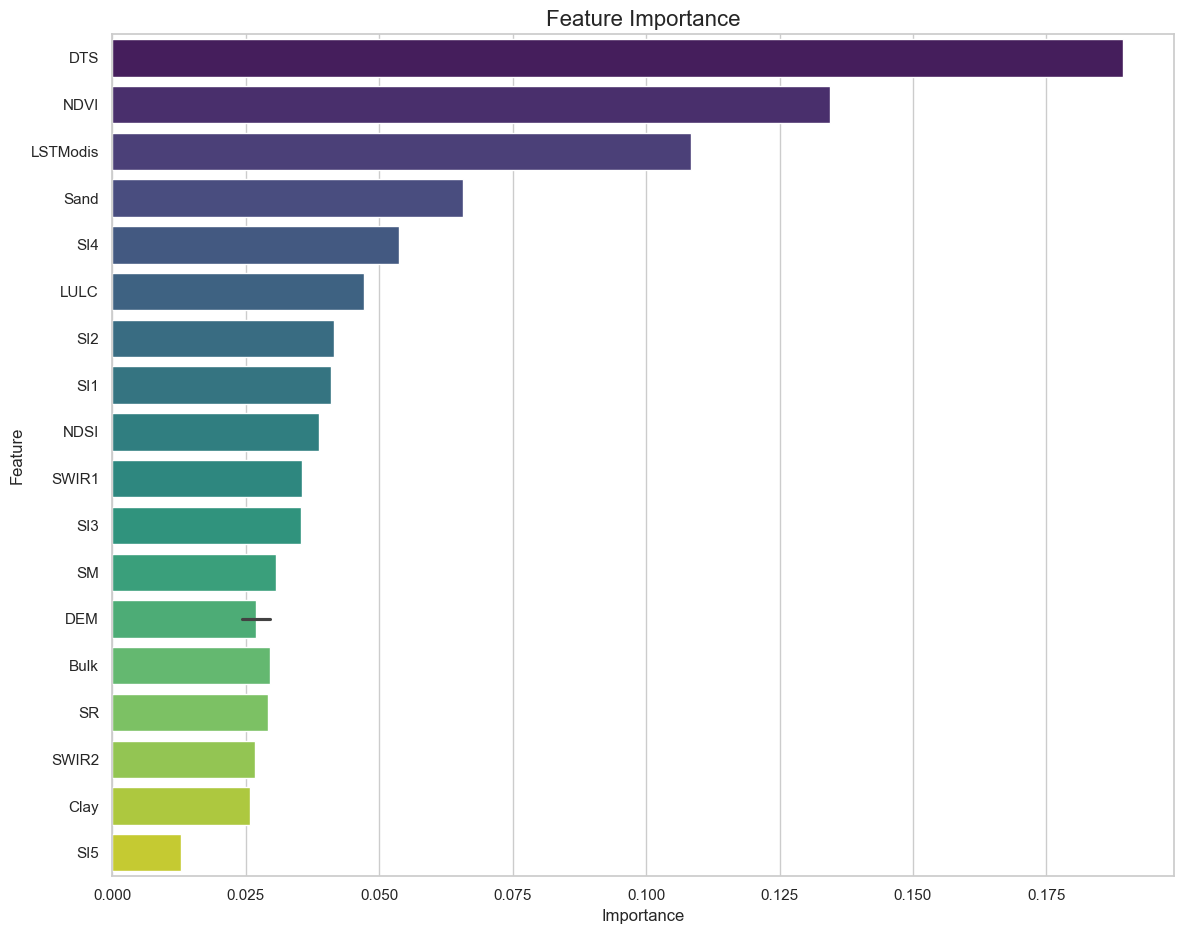

In [86]:
# ---- Feature Importance ----
importances = xgb.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, len(features) * 0.5))
sns.barplot(
    x=importances[indices], 
    y=np.array(features)[indices], 
    palette="viridis", 
    orient="h"
)
plt.title("Feature Importance", fontsize=16)
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

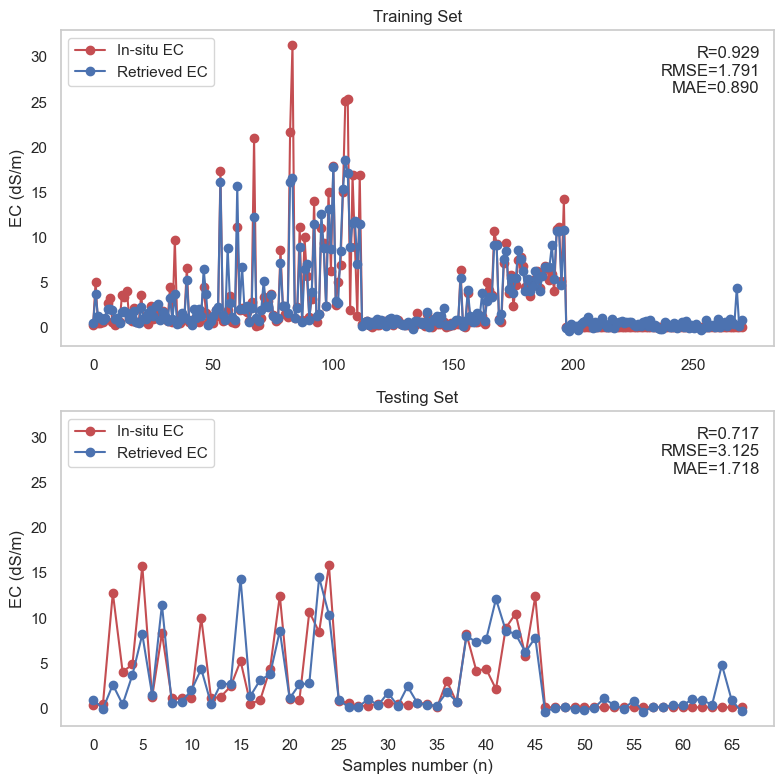

In [87]:
# ---- Prediction Plots ----
fig, axes = plt.subplots(2, 1, figsize=(8,8), sharey=True)

axes[0].grid(False)
axes[1].grid(False)

# Training set
axes[0].plot(range(len(y_train)), y_train, 'r-o', label="In-situ EC")
axes[0].plot(range(len(y_train)), y_train_pred, 'b-o', label="Retrieved EC")
axes[0].set_title("Training Set")
axes[0].set_ylabel("EC (dS/m)")
axes[0].legend()
axes[0].text(0.98, 0.95,
             f"R={np.mean(train_r2_scores):.3f}\nRMSE={np.mean(train_rmse_scores):.3f}\nMAE={np.mean(train_mae_scores):.3f}",
             transform=axes[0].transAxes, ha="right", va="top")

# Testing set
axes[1].plot(range(len(y_test)), y_test, 'r-o', label="In-situ EC")
axes[1].plot(range(len(y_test)), y_test_pred, 'b-o', label="Retrieved EC")
axes[1].set_title("Testing Set")
axes[1].set_xlabel("Samples number (n)")
axes[1].set_ylabel("EC (dS/m)")
axes[1].legend()
axes[1].text(0.98, 0.95,
             f"R={np.mean(test_r2_scores):.3f}\nRMSE={np.mean(test_rmse_scores):.3f}\nMAE={np.mean(test_mae_scores):.3f}",
             transform=axes[1].transAxes, ha="right", va="top")
axes[1].set_xticks(np.arange(0, len(y_test)+1, 5))

plt.tight_layout()
plt.show()

In [88]:
# ---- Load Raster Libraries ----
import rasterio
from rasterio.transform import Affine
from rasterio.crs import CRS
from rasterio.warp import reproject, Resampling
import geopandas as gpd
from shapely.geometry import Point
import os
from pathlib import Path

In [89]:
# ---- Load All Raster Data ----
data_folder = r'C:\data\DA\DBSCL2025\DATA ALL MONTH\DBSCL_2025_05\DATA TIFF'

raster_files = {
    'Sand': 'Sand.tif',
    'Clay': 'Clay.tif', 
    'Bulk': 'Bulk.tif',
    'LSTModis': 'LST.tif',
    'SM': 'SM.tif',
    'SR': 'SR.tif',
    'NDSI': 'NDSI.tif',
    'NDVI': 'NDVI.tif',
    'DEM': 'DEM.tif',
    'LULC': 'LULC.tif',
    'SI1': 'SI1.tif',
    'SI2': 'SI2.tif',
    'SI3': 'SI3.tif',
    'SI4': 'SI4.tif',
    'SI5': 'SI5.tif',
    'SWIR1': 'SWIR1.tif',
    'SWIR2': 'SWIR2.tif',
    'LULC': 'LULC.tif',
    'DTS': 'DTS.tif'
}

raster_data = {}
for var_name, filename in raster_files.items():
    filepath = os.path.join(data_folder, filename)
    with rasterio.open(filepath) as src:
        raster_data[var_name] = src.read(1)

with rasterio.open(os.path.join(data_folder, 'LST.tif')) as ref_src:
    reference_transform = ref_src.transform
    reference_crs = ref_src.crs
    reference_shape = ref_src.shape
    reference_bounds = ref_src.bounds

In [90]:
# ---- Prepare Data for Prediction ----
min_rows = min([data.shape[0] for data in raster_data.values()])
min_cols = min([data.shape[1] for data in raster_data.values()])

prediction_features = []
for feature_name in features:
    raster_cropped = raster_data[feature_name][:min_rows, :min_cols]
    raster_flattened = raster_cropped.flatten()
    prediction_features.append(raster_flattened)

X_prediction = np.column_stack(prediction_features)
valid_mask = ~np.any((X_prediction == -9999) | np.isnan(X_prediction), axis=1)
reference_shape = (min_rows, min_cols)

In [91]:
# ---- Train Final Model ----
df_clean = pd.read_csv(CSV_PATH)
df_clean = df_clean.loc[~(df_clean[features] == -9999).any(axis=1)].copy()
df_clean = df_clean[~df_clean[target].isna()]  # Loại bỏ NaN ở target

X_train_final = df_clean[features].values
y_train_final = df_clean[target].values

# Train final model
final_model = XGBRegressor(
    n_estimators=300,        # ít hơn vẫn được, nhưng 300 cho ổn định
    learning_rate=0.03,      # học chậm để không bắn quá xa
    max_depth=10,             # giảm sâu để bớt học noise
    min_child_weight=10,     # chống overfit cực mạnh
    subsample=0.6,           # giảm sample để tránh học quá kỹ dataset nhỏ
    colsample_bytree=0.6,    # giảm số feature/mỗi cây
    reg_alpha=5,             # tăng L1 → chống overfit
    reg_lambda=5,            # tăng L2 → chống overfit
    random_state=42,
    n_jobs=-1
)

final_model.fit(X_train_final, y_train_final)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.6, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.03, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
             max_leaves=None, min_child_weight=10, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=300,
             n_jobs=-1, num_parallel_tree=None, ...)

In [92]:
# ---- Make Spatial Predictions ----
# Initialize prediction array
predictions = np.full(len(X_prediction), np.nan)

# Make predictions only for valid pixels
if np.sum(valid_mask) > 0:
    X_valid = X_prediction[valid_mask]
    predictions_valid = final_model.predict(X_valid)
    predictions[valid_mask] = predictions_valid

# Reshape back to raster grid
prediction_raster = predictions.reshape(reference_shape)

In [93]:
# ---- Create Coordinate Grid ----
rows, cols = reference_shape
x_coords = []
y_coords = []

for row in range(rows):
    for col in range(cols):
        x, y = rasterio.transform.xy(reference_transform, row, col)
        x_coords.append(x)
        y_coords.append(y)

x_coords = np.array(x_coords)
y_coords = np.array(y_coords)

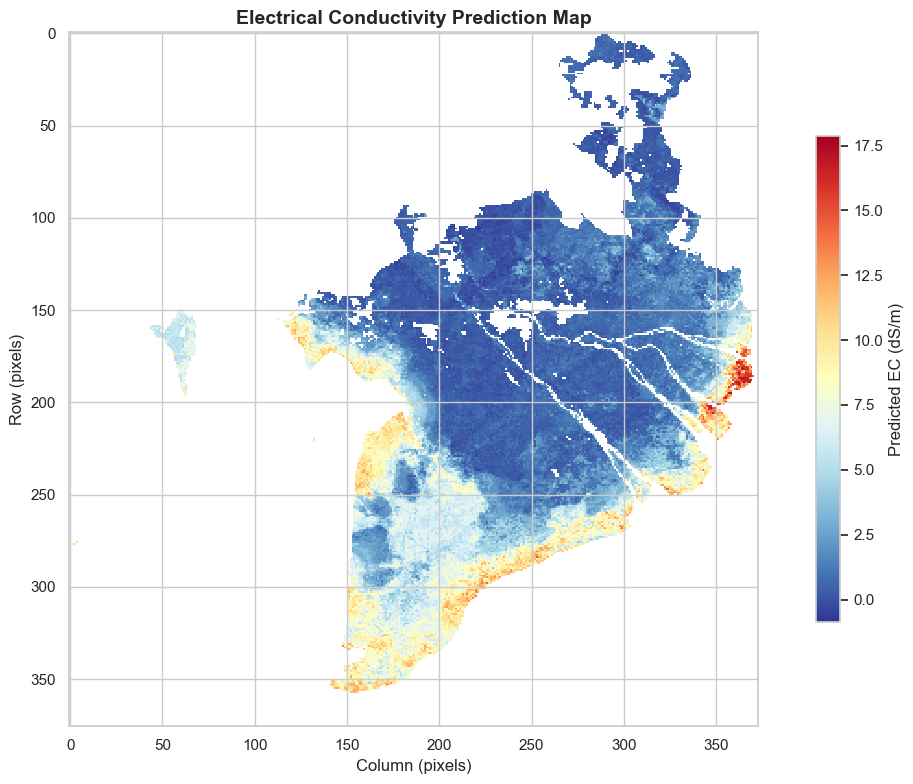

In [94]:
# ---- Visualize Prediction Map ----
plt.figure(figsize=(12, 8))

# Plot prediction map
im = plt.imshow(prediction_raster, cmap='RdYlBu_r', interpolation='nearest')
plt.colorbar(im, label='Predicted EC (dS/m)', shrink=0.7)
plt.title('Electrical Conductivity Prediction Map', fontsize=14, fontweight='bold')
plt.xlabel('Column (pixels)')
plt.ylabel('Row (pixels)')
plt.tight_layout()
plt.show()

In [95]:
# ---- Print Raster Statistics ----
# Remove NaN values for statistics calculation
valid_predictions_raster = prediction_raster[~np.isnan(prediction_raster)]
valid_predictions_raster = np.clip(valid_predictions_raster, 0, None)  # Loại bỏ giá trị âm

if len(valid_predictions_raster) > 0:
    print("=== Prediction Raster Statistics ===")
    print(f"Min EC:  {np.min(valid_predictions_raster):.4f} dS/m")
    print(f"Max EC:  {np.max(valid_predictions_raster):.4f} dS/m")
    print(f"Mean EC: {np.mean(valid_predictions_raster):.4f} dS/m")

=== Prediction Raster Statistics ===
Min EC:  0.0000 dS/m
Max EC:  17.8554 dS/m
Mean EC: 3.0862 dS/m


In [96]:
# Loại bỏ giá trị âm trước khi lưu
prediction_raster = np.clip(prediction_raster, 0, None)

output_tif = r"C:\data\DA\DBSCL2025\Map\XGB\New\Ece_Prediction_XGB5.tif"
with rasterio.open(
    output_tif,
    "w",
    driver="GTiff",
    height=prediction_raster.shape[0],
    width=prediction_raster.shape[1],
    count=1,
    dtype=prediction_raster.dtype,
    crs=reference_crs,
    transform=reference_transform,
    nodata=np.nan
) as dst:
    dst.write(prediction_raster, 1)

print(f"Prediction raster saved to {output_tif}")

Prediction raster saved to C:\data\DA\DBSCL2025\Map\XGB\New\Ece_Prediction_XGB5.tif
